In [159]:
import pandas as pd
import cptac
import numpy as np
import requests
import json
import deva
import binarization_functions_1 as bf
import sksurv
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.nonparametric import kaplan_meier_estimator

In [160]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()

In [201]:
follow_up = pd.read_excel('../Follow_Up_Data/UCEC_followup_9_12.xlsx')

In [202]:
#We are only looking at the discovery cohort, so we will separate the data into two tables based on cohort
cohort_filter = follow_up['Cohort'] == "Disc"
discovery_cohort = follow_up[cohort_filter]
other_cohort = follow_up[~cohort_filter]

In [203]:
cols_to_drop = ['Tumor code', 'ECOG Score', 
                'Karnofsky Score', 'Perform Status Scale: Timing', 
                'Other Perform Scale Timing', 
                'Specify Other New Tumor Site', 'Tamoxifen']

discovery_cohort = discovery_cohort.drop(cols_to_drop, axis=1)

for col in discovery_cohort.columns:
    if len(discovery_cohort[col].value_counts()) <= 1:
        discovery_cohort = discovery_cohort.drop(col, axis=1)
        
things_to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown', 
                     'Not Applicable', 'na', 'unknown', 'Not Performed', 
                     'Unknown tumor status', 'Unknown', 
                     'Unknown Tumor Status', 'Not specified']

for col in discovery_cohort.columns:
    discovery_cohort[col] = discovery_cohort[col].replace(things_to_replace, np.nan)

In [204]:
discovery_cohort = discovery_cohort.rename({'Case ID': 'Patient_ID'}, axis='columns')

In [205]:
patient_data = pd.merge(clinical, discovery_cohort, on = 'Patient_ID')

In [212]:
columns_to_focus_on = ['Patient_ID', 'Lost to Follow-up?', 'Vital Status', 
                       'Histologic_Grade_FIGO', 'Path Diag to Last Contact(Day)', 
                       'Cause of Death', 'Success of Initial Treatment',
                       'Path Diag to Death(days)', 'Follow-up Period',
                       'Success of Treatment@ Followup', 'Histologic_type', 
                       'New Tumor After Initial TRT',
                       'Path Diag to new Tumor (days)',]

In [219]:
focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()
focus_group_subset = focus_group[['Vital Status', 
                                  'Path Diag to Last Contact(Day)', 
                                  'Histologic_type']]
#focus_group_subset = focus_group_subset[~np.isnan(focus_group_subset['Path Diag to Last Contact(Day)'])]
#focus_group_subset = focus_group_subset[~np.isnan(focus_group_subset['Histologic_type'])]
focus_group_subset = focus_group_subset.replace('Living', False)
focus_group_subset = focus_group_subset.replace('Deceased', True)
focus_group_subset = focus_group_subset.dropna()

In [220]:
focus_group_subset

,Vital Status,Path Diag to Last Contact(Day),Histologic_type
0,False,494.0,Endometrioid
1,False,717.0,Endometrioid
2,False,737.0,Endometrioid
6,False,440.0,Endometrioid
7,False,624.0,Endometrioid
...,...,...,...
255,False,698.0,Endometrioid
256,False,401.0,Serous
257,False,774.0,Serous
258,False,199.0,Serous


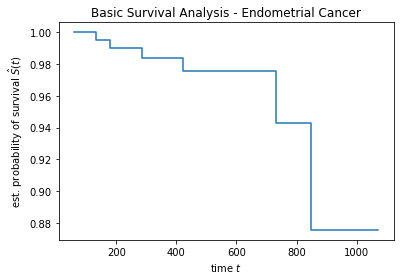

In [225]:
time, survival_prob = kaplan_meier_estimator(focus_group_subset["Vital Status"], 
                                             focus_group_subset["Path Diag to Last Contact(Day)"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Basic Survival Analysis - Endometrial Cancer")
plt.show()

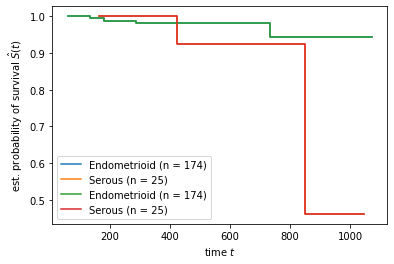

In [223]:
for value in focus_group_subset["Histologic_type"].unique():
    mask = focus_group_subset["Histologic_type"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(focus_group_subset["Vital Status"][mask],
                                                           focus_group_subset["Path Diag to Last Contact(Day)"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

In [ ]:
#Look at P53 mutations
#get_somatic_mutations, then slice out for P53, and then group_by ID
#Join mutation data with the clinical dataframe and follow_up data
#Add the p-values and the cox proportional hazard values
#Actual death-dates??